In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator
from fbprophet import Prophet
from IPython.display import HTML
from subprocess import check_output



In [13]:
#Load the data
State_time_series=pd.read_csv("State_time_series.csv",parse_dates=True)
State_time_series.Date=pd.to_datetime(State_time_series.Date)
State_time_series['year'] = State_time_series.Date.dt.year

In [14]:
#Get costliest states
states = set(State_time_series[
    ~State_time_series['ZHVI_AllHomes'].isnull() &
    ~State_time_series['Sale_Prices'].isnull()
                      ]['RegionName'].values)

State_time_series_year = State_time_series[State_time_series['RegionName'].isin(states)].copy()
highest_cost_states = State_time_series_year[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending=False)[:5].index.values.tolist()
State_time_series_year=State_time_series_year[State_time_series_year.RegionName.isin(highest_cost_states)]
State_time_series_year.year = State_time_series_year.Date.dt.year

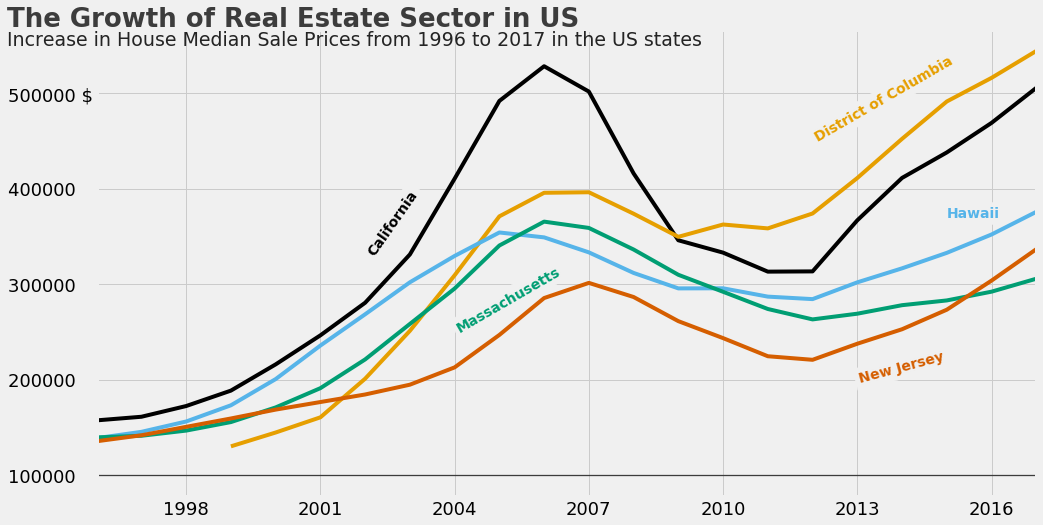

In [15]:
# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]


States_year_SalePrices=State_time_series_year.groupby([State_time_series_year.year,State_time_series_year.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='SoldPrice')
fte_graph=States_year_SalePrices.pivot(index='year', columns='RegionName', values='SoldPrice').plot(figsize=(15,8), color=colors, legend=False)
fte_graph.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.xlabel("")
fte_graph.set_yticklabels(labels = [-10, '100000   ', '200000   ',  '300000   ', '400000   ',  '500000 $'])
# Generate a bolded horizontal line at y = 0 
fte_graph.axhline(y = 100000, color = 'black', linewidth = 1.3, alpha = .7)
# Add an extra vertical line by tweaking the range of the x-axis
fte_graph.set_xlim(left = 1996, right = 2017)
# The signature bar



# Adding a title and a subtitle
fte_graph.text(x = 1994, y = 570000, s = "The Growth of Real Estate Sector in US",
               fontsize = 26, weight = 'bold', alpha = .75)
fte_graph.text(x = 1994, y = 550000, 
               s = 'Increase in House Median Sale Prices from 1996 to 2017 in the US states',
              fontsize = 19, alpha = .85)

# Add colored labels
fte_graph.text(x = 2002, y = 390000, s = 'California', color = colors[0], weight = 'bold', rotation = 55,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2012, y = 530000, s = 'District of Columbia', color = colors[1], weight = 'bold', rotation = 30,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2015, y = 370000, s = 'Hawaii', color = colors[2], weight = 'bold', rotation = 0, 
               backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2004, y = 310000, s = 'Massachusetts', color = colors[3], weight = 'bold', rotation = 30,
              backgroundcolor = '#f0f0f0')
fte_graph.text(x = 2013, y = 220000, s = 'New Jersey', color = colors[4], weight = 'bold',  rotation = 15,
              backgroundcolor = '#f0f0f0');


These are the top five States which have highest Median Sold Price.
1. DistrictOfColumbia has started from Median Selling price of less than 150 thousand dollars and crossed more than 500 thousand dollars by 2017. 
2. California started around 200 thousand dollars and has reached its highest selling price of around 470 thousand dollars in late  2006 and early 2007 and started decresing there after. 

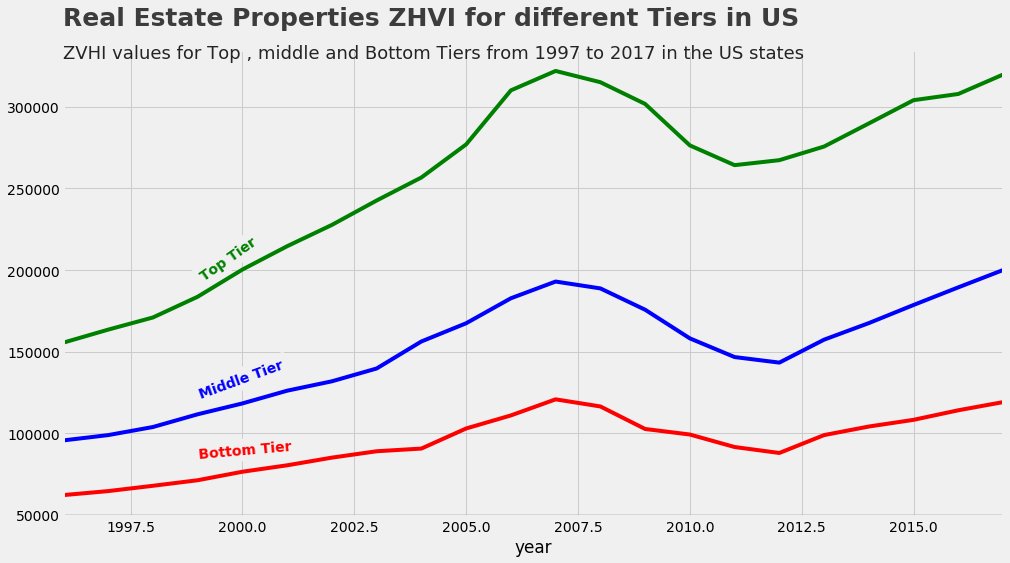

In [17]:
plt.figure(figsize=(15,8));
#plt.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

State_time_series.groupby(State_time_series['year'])['ZHVI_TopTier'].median().plot(linewidth=4,c='g')
State_time_series.groupby(State_time_series['year'])['ZHVI_MiddleTier'].median().plot(linewidth=4,c='b')
State_time_series.groupby(State_time_series['year'])['ZHVI_BottomTier'].median().plot(linewidth=4,c='r')

# Generate a bolded horizontal line at y = 0 
plt.axhline(y = 50000, color = 'black', linewidth = 1.3, alpha = .7)
# Add an extra vertical line by tweaking the range of the x-axis
plt.xlim(left = 1996, right = 2017)

# Adding a title and a subtitle
plt.text(x = 1996, y = 350000, s = "Real Estate Properties ZHVI for different Tiers in US",
               fontsize = 25, weight = 'bold', alpha = .75)
plt.text(x = 1996, y = 330000, 
               s = 'ZVHI values for Top , middle and Bottom Tiers from 1997 to 2017 in the US states',
              fontsize = 18, alpha = .85);

plt.text(x = 1999, y = 215000, s = 'Top Tier', color = 'g', weight = 'bold', rotation = 35,
              backgroundcolor = '#f0f0f0')
plt.text(x = 1999, y = 140000, s = 'Middle Tier', color = 'b', weight = 'bold', rotation = 20,
              backgroundcolor = '#f0f0f0')
plt.text(x = 1999, y = 90000, s = 'Bottom Tier', color = 'r', weight = 'bold', rotation = 5,
              backgroundcolor = '#f0f0f0');


**Zillow Home Value Index (ZHVI): **A smoothed seasonally adjusted measure of the median estimated home value across a given region and housing type. A dollar denominated alternative to repeat-sales indices. Find a more detailed methodology here: http://www.zillow.com/research/zhvi-methodology-6032/




## Prediction of 2017 House Prices with Facebook Prophet library

In [19]:
StateDF=State_time_series_year[['Date','ZHVI_AllHomes']]
StateDF.dropna(inplace=True)
#prophet expects data in the format as DF('ds','y)
StateDF['ds']=StateDF['Date']
StateDF['y']=np.log(StateDF['ZHVI_AllHomes'])

/Users/pranavprajapati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/pranavprajapati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pranavprajapati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [20]:
del StateDF['Date']
del StateDF['ZHVI_AllHomes']
StateDF.head()

,ds,y
3,1996-04-30,11.969717
19,1996-04-30,11.829924
27,1996-04-30,11.851538
41,1996-04-30,11.808576
47,1996-05-31,11.969084


In [24]:
StateDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267 entries, 3 to 13208
Data columns (total 2 columns):
ds    1267 non-null datetime64[ns]
y     1267 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.7 KB


In [25]:
train=StateDF[:len(StateDF)-40]
train.shape

(1227, 2)

In [26]:
test=StateDF[len(StateDF)-40:]
test.shape

(40, 2)

In [27]:
m = Prophet()
m.fit(StateDF);

/Users/pranavprajapati/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods=365) # days for test split
future.tail()

,ds
1627,2018-12-27
1628,2018-12-28
1629,2018-12-29
1630,2018-12-30
1631,2018-12-31


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1627,2018-12-27,12.994059,12.763719,13.216709
1628,2018-12-28,12.996440,12.773643,13.219925
1629,2018-12-29,12.998577,12.773326,13.217936
1630,2018-12-30,13.000401,12.782904,13.234874
1631,2018-12-31,13.001853,12.773665,13.221017


## Visualize Forecasted data

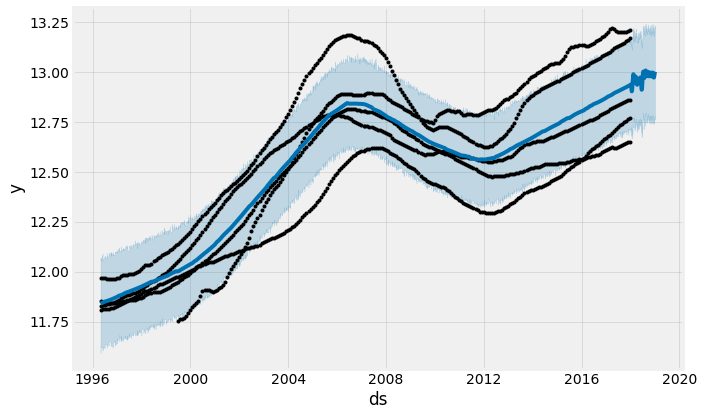

In [36]:
m.plot(forecast);

## Visualize Components of Forecasted data

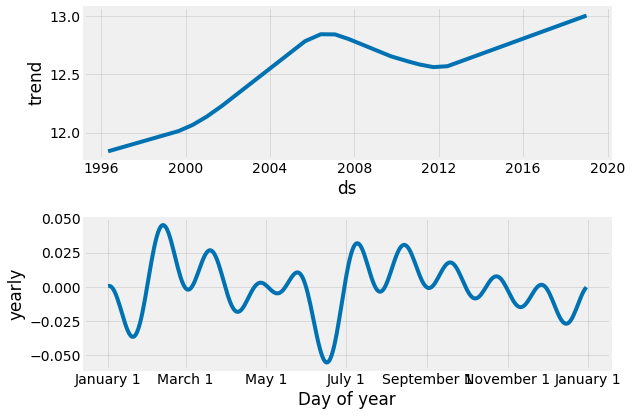

In [37]:
m.plot_components(forecast);
